## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally install and import torchensemble package for ensemble learning

In [1]:
from google.colab import drive
drive.mount('mobilenet')

Mounted at mobilenet


In [2]:
# import package

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt
from torchsummary import summary

import numpy as np
import time
import copy

In [3]:
# CIFAR10, train_ds, val_ds
transform = transforms.Compose(
    [transforms.ToTensor()])

train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

val_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Depthwise, Pointwise convolution - mobilenet을 구현하기 위한 depthwise seperable convolution
class depth_point(nn.Module):
    def __init__(self, input_size, output_size, stride=1):
        super().__init__()
        
        #groups = input_size로 depthwise convolution을 진행
        self.depthwise = nn.Sequential(
            nn.Conv2d(input_size, input_size, 3, stride=stride, padding=1, groups=input_size),
            nn.BatchNorm2d(input_size),
            nn.ReLU6(),
        )
        # kernel size를 1로 하여 pointwise convolution을 진행
        self.pointwise = nn.Sequential(
            nn.Conv2d(input_size, output_size, 1, stride=1, padding=0),
            nn.BatchNorm2d(output_size),
            nn.ReLU6()
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Channel shuffle and group convolution ---------------------------------
# 처음 group convolution 후 channel shuffle을 위한 함수
def channel_shuffle(x, groups):
    batch_size, num_channels, height, width = x.size()
    assert (num_channels % groups == 0), ('num_channels should be '
                                          'divisible by groups')
    channels_per_group = num_channels // groups

    x = x.view(batch_size, groups, channels_per_group, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batch_size, -1, height, width)
    return x

# group convolution layer - group=8로 설정하였고 batchnorm, relu
class g_conv(nn.Module):
    def __init__(self, input_size, output_size, stride=1):
        super().__init__() 

        self.gconv = nn.Sequential(
            nn.Conv2d(input_size, output_size, 3, stride=stride, padding=1, groups=8),
            nn.BatchNorm2d(output_size),
            nn.ReLU6(),
        )
    
    def forward(self, x):
        x = self.gconv(x)
        return x
#-----------------------------------------------------------------------


# MobileNetV1_shuffleNet
class MobileNetv1(nn.Module):
    def __init__(self, group=2):
        super().__init__()
        
        self.group = group
        self.init = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # dw, pw를 g_conv 하나로 변경
        self.conv4 = g_conv(32, 512, stride=2)
        
        self.conv5 = nn.Sequential(
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
        )
        # dw, pw를 g_conv 하나로 변경
        self.conv6 = nn.Sequential(
            g_conv(512, 1024, stride=2)
        )

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.init(x)
        x = self.conv4(x)
        # g_conv 후 channel shuffle
        x = channel_shuffle(x, self.group)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
def mobilenet():
    return MobileNet()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((32, 3, 32, 32)).to(device)
model = mobilenet().to(device)
output = model(x)
print('output size:', output.size())

output size: torch.Size([32, 10])


In [6]:
summary(model, (3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4            [-1, 512, 8, 8]          18,944
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
             ReLU6-6            [-1, 512, 8, 8]               0
            g_conv-7            [-1, 512, 8, 8]               0
            Conv2d-8            [-1, 512, 8, 8]           5,120
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
            ReLU6-10            [-1, 512, 8, 8]               0
           Conv2d-11            [-1, 512, 8, 8]         262,656
      BatchNorm2d-12            [-1, 512, 8, 8]           1,024
            ReLU6-13            [-1, 512, 8, 8]               0
      depth_point-14            [-1, 51

In [7]:
# define loss function, optimizer, lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = MobileNet().to(device)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.005)


# Function to train the network

def train_val(net, params_train): #, model_path='./cifar_net.pth'
    max_epoch=params_train['max_epoch']
    trainloader=params_train['train_dl']
    testloader=params_train['val_dl']
    crit=params_train['loss_func']
    opt=params_train['optimizer']
    path2weights = params_train['path2weights']
    history = []
    best_model_wts = copy.deepcopy(net.state_dict())
    start_time = time.time()
    best_loss = float('inf')
    
    for epoch in range(max_epoch):  # loop over the dataset multiple times

        print('Epoch {}/{}'.format(epoch+1, max_epoch))
        running_loss = 0.0
        running_metric = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels      
            inputs, labels = data

            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            opt.zero_grad()

            outputs = net(inputs)

            loss = crit(outputs, labels)
            loss.backward()
            opt.step()
 
            running_loss += loss.item()
            pred = outputs.argmax(1, keepdim=True)
            metric = pred.eq(labels.view_as(pred)).sum().item()
            if metric is not None:
                running_metric += metric 
        train_loss = running_loss / 50000
        train_metric = running_metric / 50000

        net.eval()
        with torch.no_grad():
            running_loss_1 = 0.0
            running_metric_1 = 0.0
            for j, data_1 in enumerate(testloader, 0):
                    # get the inputs; data is a list of [inputs, labels]

                    inputs_1, labels_1 = data_1
                    inputs_1 = inputs_1.to(device)
                    labels_1 = labels_1.to(device)
     
                    # forward
                    outputs_1 = net(inputs_1)
                    loss1 = crit(outputs_1, labels_1)
                    

                    pred1 = outputs_1.argmax(1, keepdim=True)
                    metrics = pred1.eq(labels_1.view_as(pred1)).sum().item()
                    if metrics is not None:
                       running_metric_1 += metrics
                    # print statistics
                    running_loss_1 += loss1.item()                      
            metrix = running_metric_1 / 10000
            val_loss = running_loss_1 / 10000
            
            
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), path2weights)
            print('Copied best model weights!')

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*metrix, (time.time()-start_time)/60))
        history.append(metrix)
        print('-'*10)
        

    net.load_state_dict(best_model_wts)           
    #torch.save(net.state_dict(), model_path)
    print('Finished Training')
    print('Saved Trained Model')
    return history

cuda


In [8]:
# define the training parameters
params_train = {
    'max_epoch':30,
    'optimizer':optimizer,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [9]:
history = train_val(model, params_train)

Epoch 1/30
Copied best model weights!
train loss: 1.461166, val loss: 1.188755, accuracy: 57.30, time: 1.7908 min
----------
Epoch 2/30
Copied best model weights!
train loss: 1.010566, val loss: 0.989199, accuracy: 65.28, time: 3.5704 min
----------
Epoch 3/30
Copied best model weights!
train loss: 0.796954, val loss: 0.792296, accuracy: 72.65, time: 5.3502 min
----------
Epoch 4/30
Copied best model weights!
train loss: 0.659822, val loss: 0.717966, accuracy: 75.22, time: 7.1307 min
----------
Epoch 5/30
Copied best model weights!
train loss: 0.560067, val loss: 0.709982, accuracy: 76.12, time: 8.9092 min
----------
Epoch 6/30
Copied best model weights!
train loss: 0.470984, val loss: 0.664028, accuracy: 77.43, time: 10.6866 min
----------
Epoch 7/30
train loss: 0.397875, val loss: 0.693059, accuracy: 77.88, time: 12.4677 min
----------
Epoch 8/30
Copied best model weights!
train loss: 0.336951, val loss: 0.655778, accuracy: 78.66, time: 14.2500 min
----------
Epoch 9/30
train loss: 0

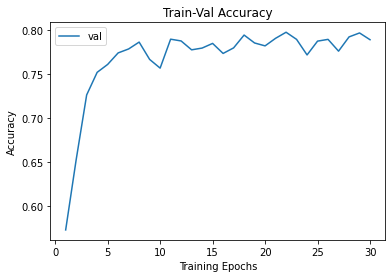

In [10]:
# train-val progress
num_epochs = params_train['max_epoch']
# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), history, label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()